In [3]:
import numpy as np
from scipy.stats import t as t_law
import matplotlib.pyplot as plt
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression, Ridge
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from multiprocessing import Pool

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

# Real Data: gasoline consumption dataset

In [5]:
data = pd.read_csv("GasolineMarket.csv")
data

,OBS,GC,PG,RI,RPN,RPT,RPU
0,1970,6.714227,-0.100947,2.943489,0.311872,-0.097374,-0.218002
1,1971,6.765328,-0.137221,2.985432,0.309661,-0.068993,-0.204794
2,1972,6.830206,-0.156660,3.033986,0.268967,-0.061672,-0.233363
3,1973,6.847757,-0.123892,3.093292,0.210451,-0.111888,-0.232193
4,1974,6.697846,0.074440,3.079637,0.160793,-0.194156,-0.295147
5,1975,6.732342,0.053035,3.089182,0.156273,-0.212513,-0.205640
6,1976,6.780673,0.037742,3.128747,0.161904,-0.174270,-0.123290
7,1977,6.809115,0.031026,3.165322,0.149898,-0.192272,-0.102431
8,1978,6.822789,0.000000,3.209507,0.150639,-0.235878,-0.155686
9,1979,6.725719,0.194642,3.215122,0.119312,-0.279452,-0.187293


In [6]:
def off_2sls(stage1, stage2, Z, X1, X2, y):
    stage1.fit(Z, X1)
    hatX1 = stage1.predict(Z)
    X = np.concatenate([hatX1, X2], axis=1)
    stage2.fit(X, y)
    r2 = stage2.score(X,y)
    haty = stage2.predict(X)
    return stage1, stage2, haty, stage1.coef_, stage2.coef_, r2

def o2sls(data, t, compare_model="linear", alpha=0.1):
    data = data.head(t)
    Z = np.array(data[["RPT", "RPN", "RPU", "RI"]]) 
    X1 = np.array(data["PG"]).reshape((-1,1))
    X2 = np.array(data["RI"]).reshape((-1,1))
    y = np.array(data["GC"]).reshape((-1,1))

    # Declare and fit comparison models
    if compare_model == 'ridge':
        stage1 = Ridge(alpha)
        stage2 = Ridge(alpha)
    elif compare_model == 'linear':
        stage1 = LinearRegression()
        stage2 = LinearRegression()

    return off_2sls(stage1, stage2, Z, X1, X2, y)

In [7]:
T = len(data.index)
sp = Ridge(0.1)
betas_otsls = [] 
r2_otsls = [] 
betas_ridge = [] 
r2_ridge = [] 
for t in range(1,T+1,1):
    stage1, stage2, haty, coef1, coef2, r2 = o2sls(data, t, compare_model="ridge", alpha=0.01)
    sp.fit(np.array(data[["PG","RI"]])[:t].reshape((-1,2)), np.array(data["GC"])[:t].reshape((-1,1)))
    r2r = sp.score(np.array(data[["PG","RI"]])[:t].reshape((-1,2)), np.array(data["GC"])[:t].reshape((-1,1)))
    betas_ridge.append(sp.coef_[0][:])
    r2_ridge.append(r2r)

    betas_otsls.append(coef2[0])
    r2_otsls.append(r2)

    
r2_ridge = np.array(r2_ridge)
r2_otsls = np.array(r2_otsls)
betas_otsls = np.array(betas_otsls)
betas_ridge = np.array(betas_ridge)

/home/rdellave/miniconda3/envs/rlberry/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/rdellave/miniconda3/envs/rlberry/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


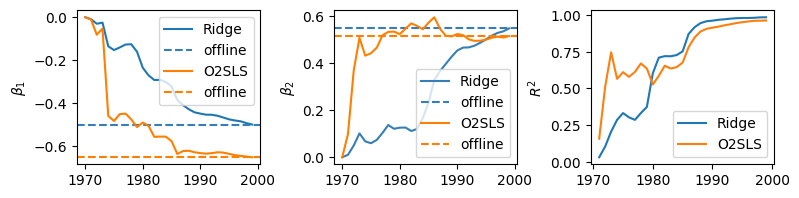

In [8]:
years = np.array(data["OBS"])
b1r = betas_ridge[:, 0]
b2r = betas_ridge[:, 1]

b1 = betas_otsls[:, 0]
b2 = betas_otsls[:, 1]

fig, axarr = plt.subplots(1, 3, figsize=(9, 2))
plt.subplots_adjust(wspace=0.4)  # Adjust the spacing between subplots

axarr[0].plot(years, b1r, label=r"Ridge")
axarr[0].axhline(y=b1r[-1], color=colors[0], linestyle='--', label="offline")
axarr[0].set_ylabel(r"$\beta_1$")
axarr[0].legend()

axarr[0].plot(years, b1, color=colors[1], label=r"O2SLS")
axarr[0].axhline(y=b1[-1], color=colors[1], linestyle='--', label="offline")
axarr[0].legend()

axarr[1].plot(years, b2r, color=colors[0], label=r"Ridge")
axarr[1].set_ylabel(r"$\beta_2$")
axarr[1].axhline(y=b2r[-1], color=colors[0], linestyle='--', label="offline")
axarr[1].legend()

axarr[1].plot(years, b2, color=colors[1], label=r"O2SLS")
axarr[1].axhline(y=b2[-1], color=colors[1], linestyle='--', label="offline")
axarr[1].legend()

axarr[2].plot(years, r2_ridge, label=r"Ridge")
axarr[2].plot(years, r2_otsls, label=r"O2SLS")
axarr[2].set_ylabel(r"$R^2$")
axarr[2].legend()
plt.savefig("./gasoline.pdf", format='pdf')

# Price-Consumption Dataset

In [10]:
data = pd.read_csv("SupplyDemand.csv")

In [11]:
X = np.array(data[["PRICE0", "PRICE1", "PRICE5", "PRICE10"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES0_1", "SALES0_5", "SALES0_10"]]).reshape((-1,4))
dim_s_f=4

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.808
-0.966
0.93
-0.973
0.977
-0.985


In [12]:
X = np.array(data[["PRICE0", "PRICE0", "PRICE0", "PRICE0"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES1_0", "SALES5_0", "SALES10_0"]]).reshape((-1,4))

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.718
-0.969
0.243
-0.942
0.076
-0.909


In [13]:
X = np.array(data[["PRICE0", "PRICE1", "PRICE5", "PRICE10"]]).reshape((-1,4))
y = np.array(data[["SALES0_0", "SALES1_1", "SALES5_5", "SALES10_10"]]).reshape((-1,4))

sp = LinearRegression()
for i in range(dim_s_f):
    sp.fit(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1)))
    print(sp.score(X[:,i].reshape((-1,1)), y[:,i].reshape((-1,1))).round(3))
    print(sp.coef_[0][0].round(3))

0.794
-0.976
0.706
-0.874
0.214
-0.273
0.064
-0.085


# Semi-synthetic dataset for Price-Consumption Dynamics

In [4]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# colors = ['#377eb8', '#ff7f00', '#66c2a5','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

type_onrec = [r"$\beta_t$", r"$R^2_t$", r"$regret$", r"Id. Regret"]

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 20
BIGGER_SIZE_A = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE_A)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_LA)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)

In [5]:
## PARAMETERS 
np.random.seed(23)
n_iters = 50
T = int(1e3)
sigma_1, sigma_2 = 1, 1 
lamda, lamda_IV = 1e-1, 1e-1 

s=[0,1, 5,20] + [40*i for i in range(1,6,1)]
f=[0,1, 5,20] + [40*i for i in range(1,6,1)]
if len(s) == len(f):
    dim_s_f = len(s)
else:
    raise ValueError("not implented different arrays")

s = np.array(s).reshape(1,1,dim_s_f)
f = np.array(f).reshape(1,dim_s_f)
theta_star = 1
beta_star = -1.
type_offrec = [r"$\beta_t$", r"$R^2_t$", r"$regret$"]

In [6]:
## MODEL 
# first stage
e = np.random.binomial(1, 0.01, size=(n_iters, T,1))
Z = np.random.randn(n_iters,T,1)*5
# Z = np.random.randn(n_iters,T,1)
eps = sigma_1*np.random.randn(n_iters,T,1)
Xmat = 5 + theta_star*Z + f*e + eps
# second stage
eta = sigma_2*np.random.randn(n_iters, T,1,1) 
Ymat = 100 + beta_star*Xmat[:,:,:,np.newaxis] + e[:,:,np.newaxis,:]*s + eta

In [7]:
XXmat = np.repeat(Xmat[:,:,:,np.newaxis], dim_s_f,axis=-1) 
X = XXmat
y = Ymat

## Offline

#### Ridge

In [21]:
options = {"beta":0, "R2":1, r"$MSE_T$":2}
choose_key = r"$MSE_T$"

In [22]:
sp = Ridge(lamda)
records_off = np.zeros((n_iters, len(type_offrec), dim_s_f, dim_s_f))

def offline_ridge(e):
    res = np.zeros((len(type_offrec), dim_s_f, dim_s_f))
    for i in range(dim_s_f):
        for j in range(dim_s_f):
            sp.fit(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            res[0, i, j] = sp.coef_[0][0]
            res[1, i, j] = sp.score(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            res[2, i, j] = np.abs(res[0,i,j]-beta_star)
    return res

with Pool() as p:
    results = p.map(offline_ridge, range(n_iters))

for e in range(n_iters):
    records_off[e] = results[e]

mean_records_off = np.mean(records_off, axis=0)
std_records_off = np.std(records_off, axis=0)

<AxesSubplot:>

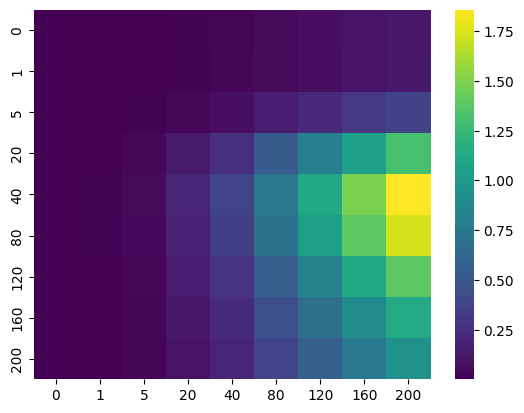

In [23]:
sns.heatmap(mean_records_off[options[choose_key],:,:], cmap="viridis", xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))
# mean_records_off[options[choose_key],:,:].round(5)

#### IV regression

In [24]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 

In [25]:
stage1 = Ridge(lamda_IV)
stage2 = Ridge(lamda_IV)

records_off_iv = np.zeros((n_iters, len(type_offrec), dim_s_f, dim_s_f))

for e in range(n_iters):
    for i in range(dim_s_f):
        for j in range(dim_s_f):
            stage1, stage2 = off_2sls_ds(stage1, stage2, Z[e,:,:], X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off_iv[e, 0, i, j] = stage2.coef_[0][0]
            records_off_iv[e, 1, i, j] = stage2.score(X[e,:,i,j].reshape((-1,1)), y[e,:,i,j].reshape((-1,1)))
            records_off_iv[e, 2, i, j] = np.abs(records_off_iv[e,0,i,j]-beta_star)

mean_records_iv = np.mean(records_off_iv[:,:,:,:], axis=0)
std_records_iv = np.std(records_off_iv, axis=0)

<AxesSubplot:>

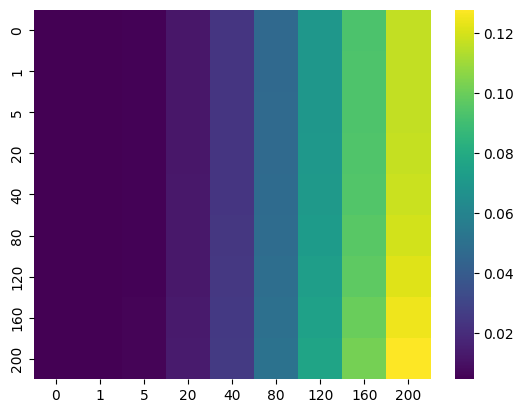

In [26]:
sns.heatmap(mean_records_iv[options[choose_key],:,:], cmap="viridis",xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))

Text(0.5, 3.722222222222216, '$\\rho_F$')

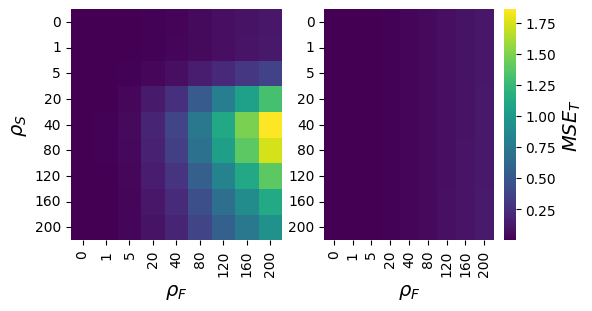

In [27]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 14
BIGGER_SIZE_A = 18

plt.rc('font', size=BIGGER_SIZE_A)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE_A)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_A)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)


# Calculate the minimum and maximum values for the color scale
min_val = min(mean_records_off[options[choose_key],:,:].min(), mean_records_iv[options[choose_key],:,:].min())
max_val = max(mean_records_off[options[choose_key],:,:].max(), mean_records_iv[options[choose_key],:,:].max())

# Set the size of the figure
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_off[options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) , vmin=min_val, vmax=max_val , cbar=False)
sns.heatmap(mean_records_iv[options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) ,vmin=min_val, vmax=max_val, cbar_kws={"label": choose_key})

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")

## Online

#### Online Ridge

In [17]:
def online_ridge(e):
    sp = Ridge(0.1)
    records_on = np.zeros((T, len(type_onrec), dim_s_f, dim_s_f))

    for t in range(1,T,1):
        for i in range(dim_s_f):
            for j in range(dim_s_f):
                sp.fit(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on[t,0,i,j] = sp.coef_[0][0]
                if t>1:
                    records_on[t,1,i,j] = sp.score(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on[t,2,i,j] = np.abs(records_on[t,0,i,j]-beta_star)
                records_on[t,3,i,j] = records_on[t-1,3,i,j] + (X[e,t,i,j]*(sp.coef_[0][0]-beta_star))**2 
    return records_on

n_jobs = 30  # Number of processes to use
with Pool(n_jobs) as p:
    records_on = np.array(p.map(online_ridge, range(n_iters)))

mean_records_on = np.mean(records_on, axis=0)
std_records_on = np.std(records_on, axis=0)

In [31]:
# import pickle
# dct_online = {"z":"var = 1", "records_on": records_on, "mean_records_on": mean_records_on, "std_records_on": std_records_on}
# with open('records_ols_2.pkl','wb') as file:
#     pickle.dump(dct_online, file)

In [67]:
import pickle

with open('records_ols_2.pkl','rb') as file:
    unpickled_ols = pickle.load(file)
    records_on = unpickled_ols["records_on"]
mean_records_on = np.mean(records_on, axis=0)
std_records_on = np.std(records_on, axis=0)

<AxesSubplot:>

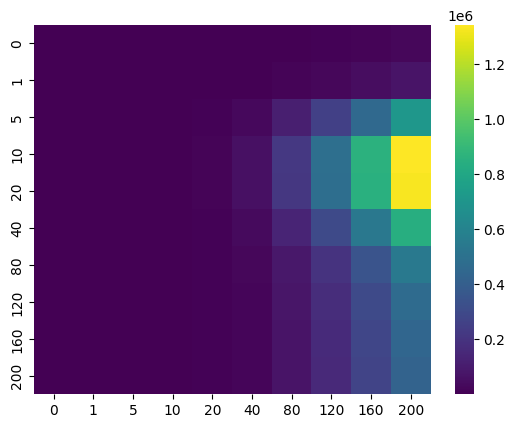

In [68]:
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

sns.heatmap(mean_records_on[-1, options[choose_key],:,:], cmap="viridis", xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()))
# mean_records_on[-1, options[choose_key],:,:].round(5)

#### O2SLS

In [19]:
def off_2sls_ds(stage1, stage2, Z, X, y):
    stage1.fit(Z, X)
    hatX = stage1.predict(Z)
    stage2.fit(hatX, y)
    haty = stage2.predict(X)
    return stage1, stage2 

In [20]:
def online_iv(e):
    records_on_iv_iter = np.zeros((T, len(type_onrec), dim_s_f, dim_s_f))
    stage1_iter = Ridge(lamda_IV)
    stage2_iter = Ridge(lamda_IV)
    for t in range(1,T,1):
        for i in range(dim_s_f):
            for j in range(dim_s_f):
                stage1_iter, stage2_iter = off_2sls_ds(stage1_iter, stage2_iter, Z[e,:t,:], X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on_iv_iter[t,0,i,j] = stage2_iter.coef_[0][0]
                if t>1:
                    records_on_iv_iter[t,1,i,j] = stage2_iter.score(X[e,:t,i,j].reshape((-1,1)), y[e,:t,i,j].reshape((-1,1)))
                records_on_iv_iter[t,2,i,j] = np.abs(records_on_iv_iter[t,0,i,j]-beta_star)
                records_on_iv_iter[t,3,i,j] = records_on_iv_iter[t-1,3,i,j] + (X[e,t,i,j]*(records_on_iv_iter[t,0,i,j]-beta_star))**2 
    return records_on_iv_iter

n_jobs = 15 # Number of processes to use
with Pool(n_jobs) as p: # number of processes to use
    records_on_iv = np.array(p.map(online_iv, range(n_iters)))

mean_records_on_iv = np.mean(records_on_iv, axis=0)
std_records_on_iv = np.std(records_on_iv, axis=0)

In [35]:
# import pickle
# dct_online_iv = {"z":"var = 1","records_on_iv": records_on_iv, "mean_records_on_iv": mean_records_on_iv, "std_records_on_iv": std_records_on_iv}
# with open('records_iv_2.pkl','wb') as f:
#     pickle.dump(dct_online_iv, f)

In [82]:
import pickle

with open('records_iv_2.pkl','rb') as file:
    unpickled_iv = pickle.load(file)
    records_on_iv = unpickled_iv["records_on_iv"]
mean_records_on_iv = np.mean(records_on_iv, axis=0)
std_records_on_iv = np.std(records_on_iv, axis=0)

<AxesSubplot:>

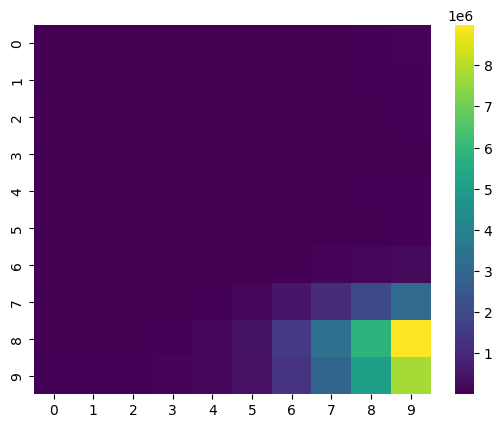

In [83]:
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

sns.heatmap(mean_records_on_iv[-1, options[choose_key],:,:], cmap="viridis")
# mean_records_on_iv[-1, options[choose_key],:,:].round(5)

#### Online Ridge VS O2SLS

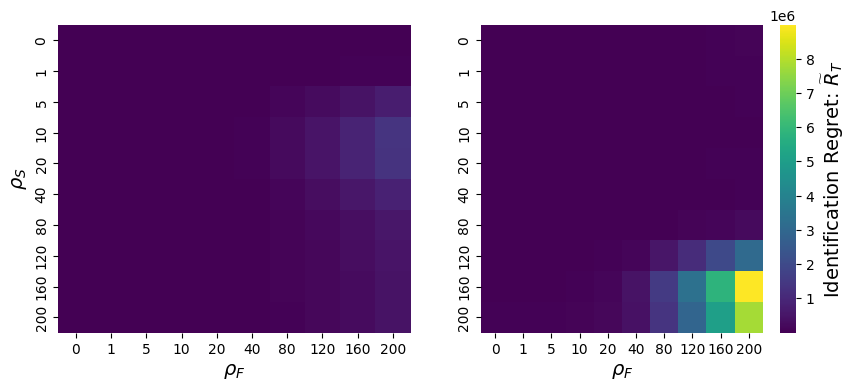

In [64]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 14
BIGGER_SIZE_A = 18

plt.rc('font', size=BIGGER_SIZE_A)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE_A)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_A)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)

options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

# Calculate the minimum and maximum values for the color scale
min_val = min(mean_records_on[-1,options[choose_key],:,:].min(), mean_records_on_iv[-1, options[choose_key],:,:].min())
max_val = max(mean_records_on[-1,options[choose_key],:,:].max(), mean_records_on_iv[-1, options[choose_key],:,:].max())

# Set the size of the figure
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the heatmaps on the subplots with the same color scale
sns.heatmap(mean_records_on[-1,options[choose_key],:,:], cmap="viridis", ax=ax[0], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) , vmin=min_val, vmax=max_val, cbar=False)
sns.heatmap(mean_records_on_iv[-1, options[choose_key],:,:], cmap="viridis", ax=ax[1], 
            xticklabels=list(f.flatten()) , yticklabels=list(s.flatten()) ,vmin=min_val, vmax=max_val, cbar_kws={"label": r"Identification Regret: $\widetilde R_T$"})

# Set the axis labels to be LaTeX formulas
ax[0].set_xlabel(r"$\rho_F$")
ax[0].set_ylabel(r"$\rho_S$")
ax[0].set_ylabel(r"$\rho_S$")
ax[1].set_xlabel(r"$\rho_F$")
# ax[1].set_ylabel(r"$\rho_S$")

# Display the plot
plt.savefig("./ols_suppdem2.pdf", format='pdf',  bbox_inches='tight')

#### Plot Learning Curves

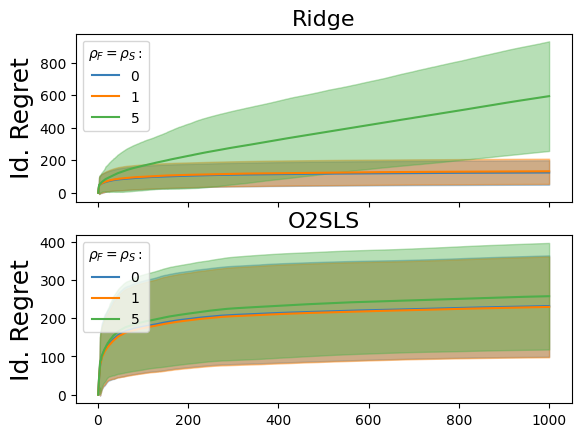

In [65]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 10
BIGGER_SIZE_A = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE_A)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_LA)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)




rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

fig, axarr = plt.subplots(2, sharex=True)
for i in range(3):
    reg = mean_records_on[:,options[choose_key],i,i]
    reg_iv = mean_records_on_iv[:,options[choose_key],i,i]
    reg_std = std_records_on[:,options[choose_key],i,i]
    reg_iv_std = std_records_on_iv[:,options[choose_key],i,i]

    axarr[0].plot(rounds, reg, label=s.flatten()[i], color=colors[i])
    axarr[0].fill_between(rounds, reg-reg_std, reg+reg_std, color=colors[i], alpha=0.4)
    axarr[0].set_title("Ridge")
    axarr[0].set_ylabel(type_onrec[options[choose_key]])
    # axarr[0].set_ylim([-1.1, 0])
    axarr[0].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the first subplot
    
    axarr[1].plot(rounds, reg_iv, label=s.flatten()[i], color=colors[i])
    axarr[1].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, color=colors[i], alpha=0.4)
    # axarr[1].set_ylabel(r"O2SLS Id. Regret: $\widetilde{R}^{O2SLS}_t$")
    axarr[1].set_title("O2SLS")
    axarr[1].set_ylabel(type_onrec[options[choose_key]])
    # axarr[1].set_ylim([-1.5, 0])
    axarr[1].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the second subplot

# plt.savefig("./id_reg_ridgeVSO2SLS.pdf", format='pdf',  bbox_inches='tight')



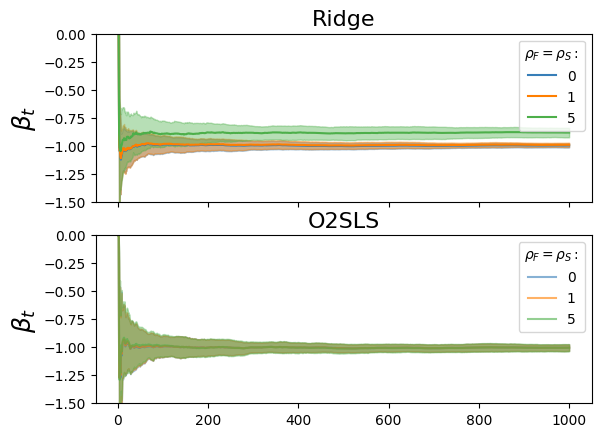

In [66]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 10
BIGGER_SIZE_A = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE_A)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_LA)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)




rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "beta"

fig, axarr = plt.subplots(2, sharex=True)
for i in range(3):
    reg = mean_records_on[:,options[choose_key],i,i]
    reg_iv = mean_records_on_iv[:,options[choose_key],i,i]
    reg_std = std_records_on[:,options[choose_key],i,i]
    reg_iv_std = std_records_on_iv[:,options[choose_key],i,i]

    axarr[0].plot(rounds, reg, label=s.flatten()[i], color=colors[i])
    axarr[0].fill_between(rounds, reg-reg_std, reg+reg_std, alpha=0.4, color=colors[i])
    axarr[0].set_title("Ridge")
    axarr[0].set_ylabel(type_onrec[options[choose_key]])
    axarr[0].set_ylim([-1.5, 0])
    axarr[0].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the first subplot
    
    axarr[1].plot(rounds, reg_iv, label=s.flatten()[i], color=colors[i], alpha=0.6)
    axarr[1].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, alpha=0.4, color=colors[i])
    # axarr[1].set_ylabel(r"O2SLS Id. Regret: $\widetilde{R}^{O2SLS}_t$")
    axarr[1].set_title("O2SLS")
    axarr[1].set_ylabel(type_onrec[options[choose_key]])
    axarr[1].set_ylim([-1.5, 0])
    axarr[1].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the second subplot

# plt.savefig("./beta_ridgeVSO2SLS.pdf", format='pdf',  bbox_inches='tight')

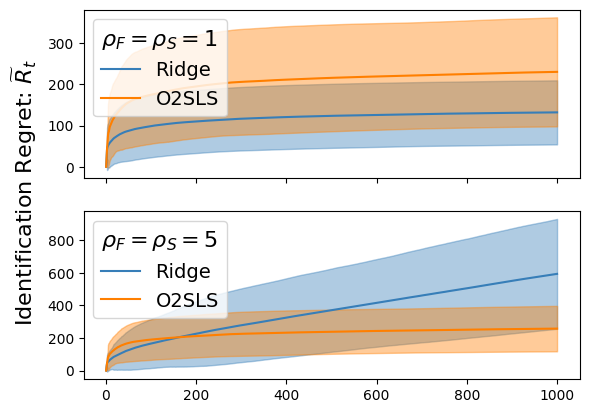

In [50]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 14
BIGGER_SIZE_A = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE_A)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE_LA)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)


rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

n_plots =2
fig, axarr = plt.subplots(n_plots, sharex=True)

# fig.text(0.03, 0.5, type_onrec[options[choose_key]], va='center', rotation='vertical', fontsize=16)
fig.text(0.01, 0.5, r"Identification Regret: $\widetilde{R}_t$", va='center', rotation='vertical', fontsize=16)


for i in range(n_plots):
    # choose elements on diagonal
    m=i+1
    reg = mean_records_on[:,options[choose_key],m,m]
    reg_iv = mean_records_on_iv[:,options[choose_key],m,m]
    reg_std = std_records_on[:,options[choose_key],m,m]
    reg_iv_std = std_records_on_iv[:,options[choose_key],m,m]

    axarr[i].plot(rounds, reg, label="Ridge", color=colors[0],)
    axarr[i].fill_between(rounds, reg-reg_std, reg+reg_std, color=colors[0], alpha=0.4)
    # axarr[i].set_title(s.flatten()[i])
    # axarr[0].set_ylim([-1.1, 0])
    # axarr[i].legend(r"$\rho_F=\rho_S = ${}".format(s.flatten()[i]) )  # Add the legend to the first subplot
    
    axarr[i].plot(rounds, reg_iv, label="O2SLS", color=colors[1])
    axarr[i].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, color=colors[1], alpha=0.4)
    # axarr[1].set_ylabel(r"O2SLS Id. Regret: $\widetilde{R}^{O2SLS}_t$")
    # axarr[i].set_title(s.flatten()[i])
    # axarr[1].set_ylim([-1.5, 0])
    axarr[i].legend(title = r"$\rho_F=\rho_S = ${}".format(s.flatten()[m]) )  # Add the legend to the second subplot

# plt.savefig("./id_reg_ridgeVSO2SLS.pdf", format='pdf',  bbox_inches='tight')


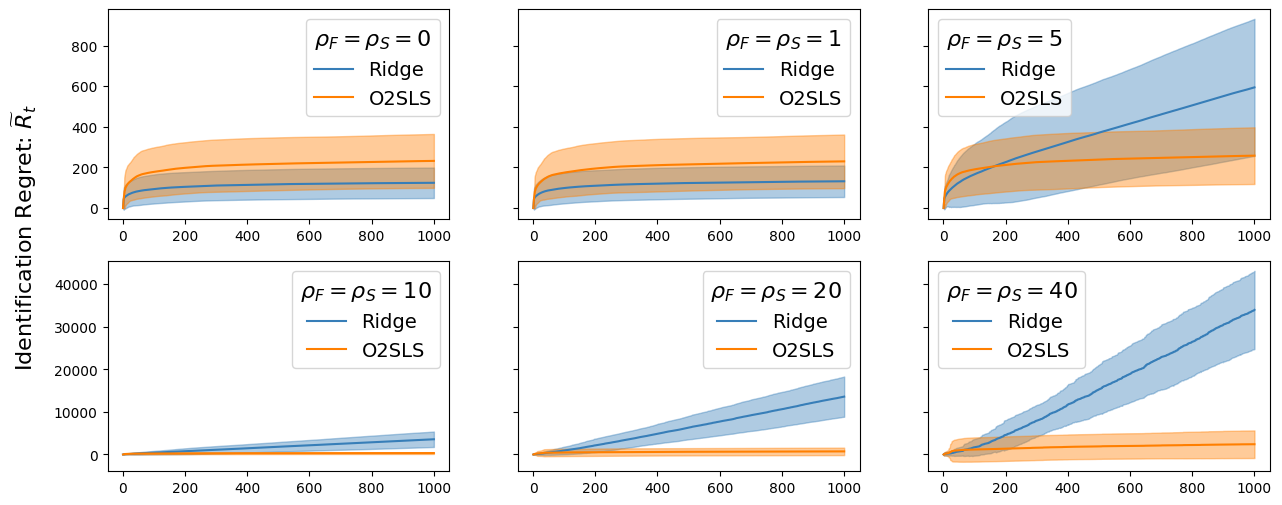

In [61]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 16
BIGGER_SIZE_LA = 14
BIGGER_SIZE_A = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE_A)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)

rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "cumreg"

l_plots = [0, 1, 2, 3, 4, 5]
fig, axarr = plt.subplots(nrows=2, ncols=(len(l_plots)//2), figsize=(15, 6), sharey='row')
fig.text(0.06, 0.5, r"Identification Regret: $\widetilde{R}_t$", va='center', rotation='vertical', fontsize=16)

for i in range(2):
    for j in range(len(l_plots)//2):
        m = l_plots[i*3+j]
        reg = mean_records_on[:, options[choose_key], m, m]
        reg_iv = mean_records_on_iv[:, options[choose_key], m, m]
        reg_std = std_records_on[:, options[choose_key], m, m]
        reg_iv_std = std_records_on_iv[:, options[choose_key], m, m]

        axarr[i, j].plot(rounds, reg, label="Ridge", color=colors[0])
        axarr[i, j].fill_between(rounds, reg-reg_std, reg+reg_std, color=colors[0], alpha=0.4)
        
        axarr[i, j].plot(rounds, reg_iv, label="O2SLS", color=colors[1])
        axarr[i, j].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, color=colors[1], alpha=0.4)
        
        axarr[i, j].legend(title=r"$\rho_F=\rho_S = ${}".format(s.flatten()[m]))

plt.savefig("./id_reg_ridgeVSO2SLS_app.pdf", format='pdf', bbox_inches='tight')


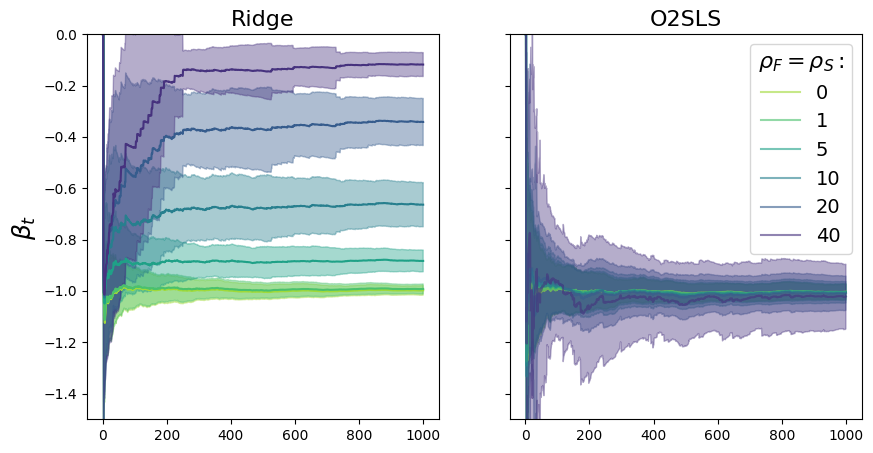

In [66]:
import seaborn as sns

# Define a color palette
palette = sns.color_palette("viridis_r", n_colors=6)

rounds = np.array([t for t in range(1,T+1,1)])
options = {"beta":0, "R2":1, "reg":2, "cumreg":3}
choose_key = "beta"

fig, axarr = plt.subplots(ncols = 2, figsize=(10,5), sharey=True)
for i in range(6):
    reg = mean_records_on[:,options[choose_key],i,i]
    reg_iv = mean_records_on_iv[:,options[choose_key],i,i]
    reg_std = std_records_on[:,options[choose_key],i,i]
    reg_iv_std = std_records_on_iv[:,options[choose_key],i,i]

    axarr[0].plot(rounds, reg, label=s.flatten()[i], color=palette[i])
    axarr[0].fill_between(rounds, reg-reg_std, reg+reg_std, alpha=0.4, color=palette[i])
    axarr[0].set_title("Ridge")
    axarr[0].set_ylabel(type_onrec[options[choose_key]])
    axarr[0].set_ylim([-1.5, 0])
    # axarr[0].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the first subplot
    
    axarr[1].plot(rounds, reg_iv, label=s.flatten()[i], color=palette[i], alpha=0.6)
    axarr[1].fill_between(rounds, reg_iv-reg_iv_std, reg_iv+reg_iv_std, alpha=0.4, color=palette[i])
    # axarr[1].set_ylabel(r"O2SLS Id. Regret: $\widetilde{R}^{O2SLS}_t$")
    axarr[1].set_title("O2SLS")
    # axarr[1].set_ylabel(type_onrec[options[choose_key]])
    axarr[1].set_ylim([-1.5, 0])
    axarr[1].legend(title=r"$\rho_F=\rho_S:$")  # Add the legend to the second subplot

# plt.savefig("./beta_ridgeVSO2SLS.pdf", format='pdf',  bbox_inches='tight')
